In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
import folktexts
print(f"{folktexts.__version__=}")

folktexts.__version__='0.0.2'


In [3]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

Global constants:

In [4]:
LLM_CACHE_DIR = "/Users/acruz/data/transformers-cache"
# LLM_CACHE_DIR = "/fast/acruz/huggingface-models"

# MODEL_NAME = "gpt2"
# MODEL_NAME = "google/gemma-1.1-2b-it"
MODEL_NAME = "google/gemma-2b"

SEED = 42
rng = np.random.default_rng(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "mps"

In [5]:
from folktexts.llm_utils import load_model_tokenizer
model, tokenizer = load_model_tokenizer(MODEL_NAME, cache_dir=LLM_CACHE_DIR)
model.to(DEVICE);

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
from folktexts.acs import ACSFolktablesDataset

acs_income_data = ACSFolktablesDataset(task_name="ACSIncome", val_size=0, subsampling=0.001)
acs_income_data

In [7]:
X_test, y_test = acs_income_data.get_test()
print(f"{X_test.shape=}")

X_test.shape=(167, 10)


In [8]:
X_train, y_train = acs_income_data.get_train()
print(f"{X_train.shape=}")

X_train.shape=(1497, 10)


---

Example row:

In [9]:
n=5
example_indices = rng.permutation(len(X_train))[:n]

X_train = X_train.iloc[example_indices]
y_train = y_train.iloc[example_indices]
y_train

1062573    1
703768     1
1094545    1
865470     0
786195     0
Name: PINCP_binary, dtype: int64

In [10]:
import importlib
import folktexts.prompting
import folktexts.decoding
importlib.reload(folktexts)
importlib.reload(folktexts.prompting)
importlib.reload(folktexts.decoding)

<module 'folktexts.decoding' from '/Users/acruz/Documents/folktexts/folktexts/decoding.py'>

In [11]:
from folktexts.prompting import encode_row_prompt

row_prompts = [
    encode_row_prompt(row, dataset=acs_income_data)
    for _, row in X_train.iterrows()
]
print(row_prompts[0], end="**")

The following data corresponds to a survey respondent. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is 54 years old.
- The current employment status is working for a for-profit private company or organization.
- The highest grade completed is Bachelor's degree.
- The marital status is divorced.
- The occupation is software developers.
- The place of birth is Georgia/GA.
- The relationship to the reference person in the household is the 'reference person' itself.
- The usual number of hours worked per week is 40 hours.
- The sex is Male.
- The race is White.

Question: What is this person's estimated yearly income?
A. Below $50,000.
B. Above $50,000.
Answer:**

In [44]:
[len(p) for p in full_prompts]

[1164, 1164, 1206, 1185, 1166]

In [12]:
from folktexts.prompting import apply_chat_template, SYSTEM_PROMPT
full_prompts = [
    apply_chat_template(tokenizer, SYSTEM_PROMPT + "\n" + row_p, system_prompt=False)
    for row_p in row_prompts
]
print(full_prompts[0], end="**")


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



<|im_start|>user
You are a helpful assistant. You answer multiple-choice questions based on the information provided. Your answer should start with a single letter representing the choice you think is correct. The data provided is enough to reach an approximate answer. Please answer with your best estimate.

The following data corresponds to a survey respondent. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is 54 years old.
- The current employment status is working for a for-profit private company or organization.
- The highest grade completed is Bachelor's degree.
- The marital status is divorced.
- The occupation is software developers.
- The place of birth is Georgia/GA.
- The relationship to the reference person in the household is the 'reference person' itself.
- The usual number of hours worked per week is 40 hours.
- The sex is Male.
- The race is White.

Question: What is this p

In [13]:
def max_n_tokens(probs_sequences: list[list[float]], tokenizer, n=5) -> list[list[str]]:
    return [
        [
            tokenizer.decode(tok_id)
            for tok_id in np.argsort(p_seq)[-n:]
        ]
        for p_seq in probs_sequences
    ]

Querying the model:

In [14]:
%%time
from folktexts.querying import query_model_batch

probs_row_prompts = query_model_batch(row_prompts, model, tokenizer, context_size=512)
probs_full_prompts = query_model_batch(full_prompts, model, tokenizer, context_size=512)

CPU times: user 367 ms, sys: 1.92 s, total: 2.28 s
Wall time: 5.99 s


In [15]:
from folktexts.decoding import get_answer_to_question, get_risk_estimate_from_answers

for i in range(len(y_train)):
    # Answers using simple row template
    row_answers = get_answer_to_question(acs_income_data.question, probs_row_prompts[i], tokenizer)
    row_risk_estimate = get_risk_estimate_from_answers(row_answers)

    # Answers using full chat template
    chat_answers = get_answer_to_question(acs_income_data.question, probs_full_prompts[i], tokenizer)
    chat_risk_estimate = get_risk_estimate_from_answers(chat_answers)
    
    print(f"{i} :: label={y_train.iloc[i]}")
    print(f"\t row-prompts:  {row_risk_estimate}")
    print(f"\t row-prompts:  {row_answers}")
    print("\n")
    print(f"\t full-prompts: {chat_risk_estimate}")
    print(f"\t full-prompts: {chat_answers}")
    print("\n\n")


DEBUG:root:prefix='' has density 0.22%
DEBUG:root:prefix=' ' has density 37.36%
INFO:root:Answers have 37.36% probability assigned.
DEBUG:root:prefix='' has density 0.02%
DEBUG:root:prefix=' ' has density 24.81%
INFO:root:Answers have 24.81% probability assigned.
DEBUG:root:prefix='' has density 0.20%
DEBUG:root:prefix=' ' has density 38.41%
INFO:root:Answers have 38.41% probability assigned.
DEBUG:root:prefix='' has density 0.02%
DEBUG:root:prefix=' ' has density 24.74%
INFO:root:Answers have 24.74% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 37.57%
INFO:root:Answers have 37.57% probability assigned.
DEBUG:root:prefix='' has density 0.01%
DEBUG:root:prefix=' ' has density 23.40%
INFO:root:Answers have 23.40% probability assigned.
DEBUG:root:prefix='' has density 0.28%
DEBUG:root:prefix=' ' has density 37.50%
INFO:root:Answers have 37.50% probability assigned.
DEBUG:root:prefix='' has density 0.02%
DEBUG:root:prefix=' ' has density 27.

0 :: label=1
	 row-prompts:  0.4906617242998033
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.5093382757001966, Choice(text='Above $50,000', value=1, numeric_value=None): 0.4906617242998033}


	 full-prompts: 0.6571721875298309
	 full-prompts: {Choice(text='Below $50,000', value=0, numeric_value=None): 0.3428278124701692, Choice(text='Above $50,000', value=1, numeric_value=None): 0.6571721875298309}



1 :: label=1
	 row-prompts:  0.5038704098908807
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.49612959010911933, Choice(text='Above $50,000', value=1, numeric_value=None): 0.5038704098908807}


	 full-prompts: 0.6618388125884492
	 full-prompts: {Choice(text='Below $50,000', value=0, numeric_value=None): 0.3381611874115507, Choice(text='Above $50,000', value=1, numeric_value=None): 0.6618388125884492}



2 :: label=1
	 row-prompts:  0.5084399511793466
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None):

In [16]:
print("Highest likelihood tokens for row prompts")
max_n_tokens(probs_row_prompts, tokenizer, n=5)

Highest likelihood tokens for row prompts


[['<eos>', ' C', '\n', ' B', ' A'],
 [' Below', ' C', '\n', ' A', ' B'],
 ['<eos>', ' C', '\n', ' A', ' B'],
 [' Below', ' C', '\n', ' B', ' A'],
 ['<eos>', ' C', '\n', ' B', ' A']]

In [17]:
print("Highest likelihood tokens for CHAT prompts")
max_n_tokens(probs_full_prompts, tokenizer, n=5)

Highest likelihood tokens for CHAT prompts


[['...', ' A', ' <', ':', ' B'],
 ['...', ' A', ' <', ':', ' B'],
 ['...', ' A', ' <', ' B', ':'],
 ['...', ' <', ' A', ':', ' B'],
 ['...', ' A', ' <', ' B', ':']]

In [18]:
%%time
import torch
# tok_ids = tokenizer.encode(row_prompts[0])
tok_ids = tokenizer.encode(full_prompts[0])
out_ids = model.generate(
    torch.tensor(tok_ids).reshape(1,-1).to("mps"),
    pad_token_id=tokenizer.pad_token_id,
    max_new_tokens=100,
)
print(tokenizer.decode(out_ids[0]))

<bos><|im_start|>user
You are a helpful assistant. You answer multiple-choice questions based on the information provided. Your answer should start with a single letter representing the choice you think is correct. The data provided is enough to reach an approximate answer. Please answer with your best estimate.

The following data corresponds to a survey respondent. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is 54 years old.
- The current employment status is working for a for-profit private company or organization.
- The highest grade completed is Bachelor's degree.
- The marital status is divorced.
- The occupation is software developers.
- The place of birth is Georgia/GA.
- The relationship to the reference person in the household is the 'reference person' itself.
- The usual number of hours worked per week is 40 hours.
- The sex is Male.
- The race is White.

Question: What is t

---

In [19]:
from folktexts.querying import compute_task_risk_estimates

results = compute_task_risk_estimates(
    model=model,
    tokenizer=tokenizer,
    dataset=acs_income_data,
)

  0%|          | 0/188 [00:00<?, ?it/s]

DEBUG:root:prefix='' has density 0.20%
DEBUG:root:prefix=' ' has density 38.17%
INFO:root:Answers have 38.17% probability assigned.
DEBUG:root:prefix='' has density 0.26%
DEBUG:root:prefix=' ' has density 36.52%
INFO:root:Answers have 36.52% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 36.91%
INFO:root:Answers have 36.91% probability assigned.
DEBUG:root:prefix='' has density 0.22%
DEBUG:root:prefix=' ' has density 38.91%
INFO:root:Answers have 38.91% probability assigned.
DEBUG:root:prefix='' has density 0.28%
DEBUG:root:prefix=' ' has density 42.20%
INFO:root:Answers have 42.20% probability assigned.
DEBUG:root:prefix='' has density 0.31%
DEBUG:root:prefix=' ' has density 39.15%
INFO:root:Answers have 39.15% probability assigned.
DEBUG:root:prefix='' has density 0.26%
DEBUG:root:prefix=' ' has density 36.63%
INFO:root:Answers have 36.63% probability assigned.
DEBUG:root:prefix='' has density 0.27%
DEBUG:root:prefix=' ' has density 37.

  0%|          | 0/21 [00:00<?, ?it/s]

DEBUG:root:prefix='' has density 0.28%
DEBUG:root:prefix=' ' has density 35.88%
INFO:root:Answers have 35.88% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 37.02%
INFO:root:Answers have 37.02% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 37.78%
INFO:root:Answers have 37.78% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 37.07%
INFO:root:Answers have 37.07% probability assigned.
DEBUG:root:prefix='' has density 0.22%
DEBUG:root:prefix=' ' has density 36.63%
INFO:root:Answers have 36.63% probability assigned.
DEBUG:root:prefix='' has density 0.21%
DEBUG:root:prefix=' ' has density 37.45%
INFO:root:Answers have 37.45% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 36.24%
INFO:root:Answers have 36.24% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 37.

In [20]:
from sklearn.metrics import RocCurveDisplay, accuracy_score, balanced_accuracy_score

_X, y_train = acs_income_data.get_train()
y_train_pred = results["train"]
print(f"accuracy: {accuracy_score(y_true=y_train, y_pred=y_train_pred >= 0.5)}")
print(f"Bal. accuracy: {balanced_accuracy_score(y_true=y_train, y_pred=y_train_pred >= 0.5)}")

accuracy: 0.6225784903139613
Bal. accuracy: 0.6446621998883306


In [21]:
logging.getLogger().setLevel(logging.INFO)

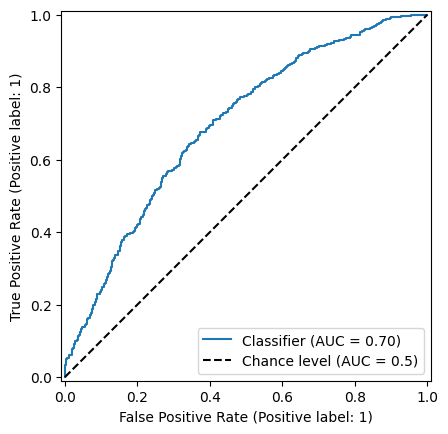

In [22]:
RocCurveDisplay.from_predictions(y_true=y_train, y_pred=y_train_pred, plot_chance_level=True)

<Axes: ylabel='Count'>

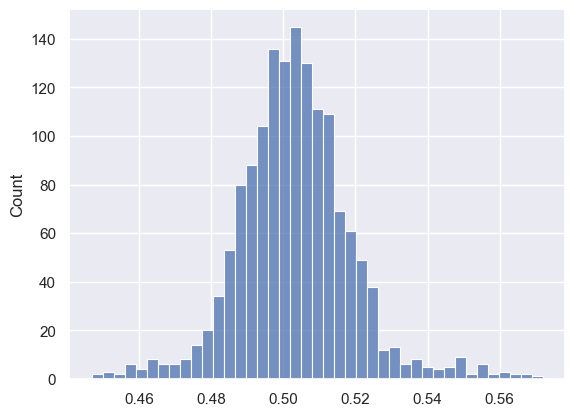

In [27]:
import seaborn as sns
sns.histplot(y_train_pred)

In [28]:
df = pd.DataFrame({"score": y_train_pred, "label": y_train}).reset_index(drop=True)
df.head()

,score,label
0,0.487488,1
1,0.515711,0
2,0.505362,1
3,0.498199,1
4,0.528175,1


(0.44694844033417297, 0.5718849717242209)

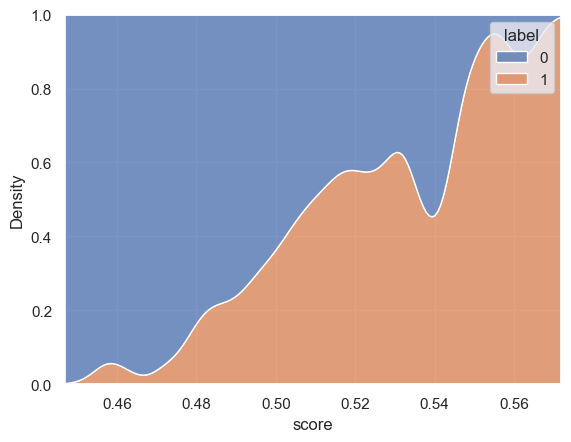

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.kdeplot(df, x="score", hue="label", multiple="fill")
plt.xlim(y_train_pred.min(), y_train_pred.max())

In [40]:
import importlib
import folktexts.evaluation
importlib.reload(folktexts.evaluation)

<module 'folktexts.evaluation' from '/Users/acruz/Documents/folktexts/folktexts/evaluation.py'>

In [41]:
import folktexts.evaluation
from pathlib import Path

results = folktexts.evaluation.evaluate_predictions(
    y_true=y_train,
    y_pred_scores=y_train_pred,
    imgs_dir=Path("../imgs"),
)
results

{'accuracy': 0.6459585838343354,
 'tpr': 0.6750418760469011,
 'fnr': 0.3249581239530988,
 'fpr': 0.37333333333333335,
 'tnr': 0.6266666666666667,
 'balanced_accuracy': 0.650854271356784,
 'precision': 0.5453315290933695,
 'ppr': 0.49365397461589844,
 'log_loss': 0.6848018239572005,
 'brier_score_loss': 0.2458335879398815,
 'roc_auc': 0.6950307091010608,
 'roc_curve_path': '/Users/acruz/Documents/folktexts/imgs/roc_curve.png',
 'calibration_curve_path': '/Users/acruz/Documents/folktexts/imgs/calibration_curve.png',
 'score_distribution_path': '/Users/acruz/Documents/folktexts/imgs/score_distribution.png',
 'score_distribution_per_label_path': '/Users/acruz/Documents/folktexts/imgs/score_distribution_per_label.png'}

In [26]:
# TODO: does the curve change downwards if we add a base rate to the prompt? like "Note that half of the population earns below 50K per year".